#imports & reading in the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
plt.figure(figsize=(12, 8))

diagnosis_df = pd.read_csv("diagnosis.csv")
labs_df = pd.read_csv("labs.csv")
medications_df = pd.read_csv("medications.csv")
operations_df = pd.read_csv("operations.csv")

<Figure size 1200x800 with 0 Axes>

# determining operation types using ICD-10 code

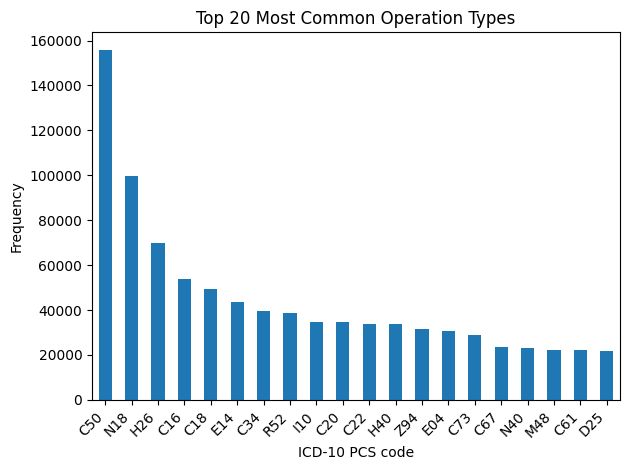

In [ ]:
operation_types = diagnosis_df["icd10_cm"].value_counts()

top_n = 20
top_operation_types = operation_types.head(top_n)

top_operation_types.plot(kind='bar')
plt.title(f'Top {top_n} Most Common Operation Types')
plt.xlabel('ICD-10 PCS code')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#total unique operation types

In [ ]:
unique_operations = diagnosis_df['icd10_cm'].unique()

unique_operations_count = len(unique_operations)
total_operations_count = len(diagnosis_df)

print(f"There are {unique_operations_count} operations with unique ICD-10 codes out of a total of {total_operations_count} operations in the dataset")

There are 1136 operations with unique ICD-10 codes out of a total of 2464620 operations in the dataset


#medications EDA

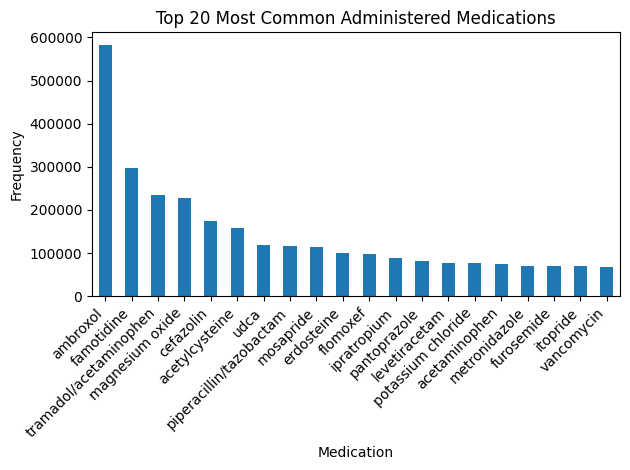

In [ ]:
most_administered_meds = medications_df['drug_name'].value_counts()

top_n = 20
top_meds = most_administered_meds.head(top_n)

top_meds.plot(kind='bar')
plt.title(f'Top {top_n} Most Common Administered Medications')
plt.xlabel('Medication')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#total unique medications administered

In [ ]:
unique_medications = medications_df['drug_name'].unique()

unique_medications_count = len(unique_medications)
total_medications_count = len(medications_df)

print(f"There are {unique_medications_count} unique administered medications out of a total of {total_operations_count} operations in the dataset")

There are 1189 unique administered medications out of a total of 2464620 operations in the dataset


#Predicting in hospital death within 30 days after operation

214/68113 (0.31%) train, 102/29191 (0.35%) test, 18 features
ASA auroc: 0.829, auprc: 0.101
LR auroc: 0.964, auprc: 0.199
GBM auroc: 0.968, auprc: 0.181


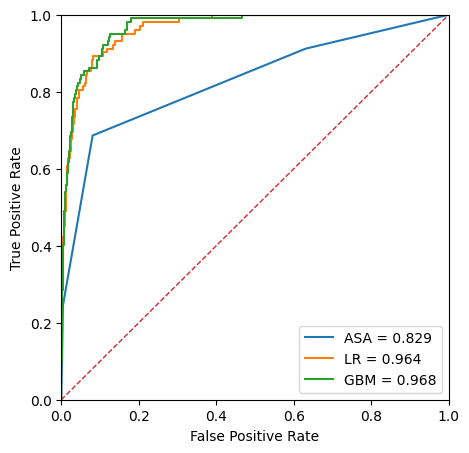

In [ ]:
import numpy as np
import pandas as pd

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']

# Load operations
df = pd.read_csv('operations.csv')

# find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)
df = df[(df['asa'] < 6)]
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
df_lab = pd.read_csv('labs.csv')
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                    left_on='orin_time', right_on='chart_time', by='subject_id',
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

df['sex'] = df['sex'] == 'M'

#print(df.astype({'inhosp_death_30day':int}).quantile([0, 0.25, 0.5, 0.75, 1]))
# Split a dataset into train and test sets
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)
y_train = df.loc[:ntrain, OUTCOME_VAR]
x_train = df.loc[:ntrain, INPUT_VARS].astype(float)
y_test = df.loc[ntrain:, OUTCOME_VAR]
x_test = df.loc[ntrain:, INPUT_VARS].astype(float)

# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

# ASA class
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)

# Logistic regression using SimpleImputer()
from sklearn.impute import SimpleImputer
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression()
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)

# Gradient Boosting using XGBClassifier()
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss')
model.fit(x_train, y_train)
y_pred_gbm = model.predict_proba(x_test)[:, 1]

# Compute AUROC and AUPRC
auroc_gbm = roc_auc_score(y_test, y_pred_gbm)
prc_gbm, rec_gbm, thresholds = precision_recall_curve(y_test, y_pred_gbm)
auprc_gbm = auc(rec_gbm, prc_gbm)
print(f'GBM auroc: {auroc_gbm:.3f}, auprc: {auprc_gbm:.3f}', flush=True)

import matplotlib.pyplot as plt

fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)

plt.figure(figsize=(5,5))
plt.plot(fpr_asa, tpr_asa, label='ASA = {:0.3f}'.format(auroc_asa))
plt.plot(fpr_lr, tpr_lr, label='LR = {:0.3f}'.format(auroc_lr))
plt.plot(fpr_gbm, tpr_gbm, label='GBM = {:0.3f}'.format(auroc_gbm))
plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('auroc.png')

#propofol / d33 EDA

In [ ]:
# just d33 patients
d33 = diagnosis_df[diagnosis_df['icd10_cm'] == "D33"]

# Set binary_column to 1 where drug_name = propofol & 0 for any other anytype
medications_df['binary_column'] = 0
medications_df.loc[medications_df['drug_name'] == "propofol", 'binary_column'] = 1

# just propofol patients
propofol = medications_df[medications_df['binary_column'] == 1]
unique_propofol_patients = propofol.drop_duplicates(subset='subject_id')

In [ ]:
# creating a list of unique propofol patient subject_ids
propofol_subject_ids = unique_propofol_patients["subject_id"].tolist()

# checking which unique subject_ids were administered propofol & have d33 diagnosis
matching_subject_ids = d33[d33['subject_id'].isin(propofol_subject_ids)]
unique_matching_subject_ids = matching_subject_ids.drop_duplicates(subset="subject_id")

len(unique_matching_subject_ids)

15